### Downsampling

In this analysis, we have called peaks (macs2 in each replicate, then idr peaks on the results of the macs2 peaks) in all stages, with increasingly lower number of reads. 

For example, the file in     

    data/atac_peaks/downsampling/zebra_danRer10_8som_15600000_idr01Peaks.bed.gz    
    
is idr atac peaks called with 15600000 reads (in each replicate) of the reads from the 8somite zebrafish experiments which means that its coverage (15600000/avail_genome['zebra'] ) is 0.89 (we'll call it 90%) of the amphioxus coverage (9200000/ avail_genome['amphi'])

The number of reads was chosen so as to have 100%, 90%, 80% etc of the amphioxus number.    
    
The question is, do we still have more peaks in the vertebrates with worse (less reads) experiments?

In [1]:
# assign genomic regions to the genes
greg = gr_great

print( [(k,len(v)) for k,v in greg.items()])

[('Dre', 20053), ('Bla', 20569), ('Ola', 15978), ('Mmu', 18842)]


In [2]:
stages = {}
stages['Bla'] = ['15']
stages['Dre'] = ["8som"]
stages['Ola'] = ["8som"]

In [3]:
# some hardcoded numbers
df = pd.DataFrame([['zebra', 1371719383, 1369631918, 756790655, 756666441,
        0.5517095292076951, 0.0015217872006989541, 612841263, 653072511],
       ['amphi', 495353434, 474881800, 152452412, 152231682,
        0.3077649240642995, 0.041327328317259604, 322429388, 347547588],
       ['medaka', 869000216, 700386597, 23221380, 23181494,
        0.026721949629526905, 0.19403173427979903, 677165217, 846778620]])
df.columns = ['species','genome','genome_notN','repMask','repnotN',
      '% genome in repM','% genome is N','effective','previous_effective']

In [4]:
df

species      genome  genome_notN    repMask    repnotN  % genome in repM  \
0   zebra  1371719383   1369631918  756790655  756666441          0.551710   
1   amphi   495353434    474881800  152452412  152231682          0.307765   
2  medaka   869000216    700386597   23221380   23181494          0.026722   

   % genome is N  effective  previous_effective  
0       0.001522  612841263           653072511  
1       0.041327  322429388           347547588  
2       0.194032  677165217           846778620

We will normalize the number of reads based on the amount of available genome in each species.    
That is the total genome minus the regions covered by the repeat masker.    
    
Unintuitively, medaka ends up with more available genome that zebrafish because of the very large number
of blacklisted regions in zebrafish.

In [5]:
avail_genome = dict(df[['species','effective']].to_records(index=False))
avail_genome

{'zebra': 612841263, 'amphi': 322429388, 'medaka': 677165217}

This is how many reads the bla sample has.
It was much easier to hard code this number than to count in this notebook:


In [6]:
# We calculate coverage as the 
# #ofReads per kilobase of available genome:
Bla_coverage = 9200000*1000/ avail_genome['amphi']
# the percentages are not exactly 70 or 80 etc, 
#so we will force-smooth them 
# a tiny bit to make the graphs better.
fixcols =[1,10,20,30,40,50,60,70,80,90,100]

We have the downsample series in the data subfolder, so lets load them up:

In [7]:
greg_ = BT().from_dataframe(greg['Dre']).sort()
pre_cols = ['chrom','start','end','gene','width','strand']
cols = []

for thing in glob(
    "../data/atac_peaks/downsampling/zebra_danRer10_8som_*_idr01Peaks.bed.gz"):
    reads = int(re.findall(r"[0-9]+", thing)[2])
    
    #     The coverage in this experiment:
    cov = reads*1000/avail_genome['zebra']
    #    The coverage in relation to the Bla one
    cov = round(cov*100 / Bla_coverage,2)
    cov = int(round(cov))
    cols.append( cov )
    greg_ = greg_.intersect(b=BT( thing ), nonamecheck=True, c=True)

counts_Dre = greg_.to_dataframe(names=pre_cols+cols)   
counts_Dre = counts_Dre[pre_cols+ sorted(cols)]
counts_Dre.columns = pre_cols + fixcols
dre_melt = pd.melt(counts_Dre[['gene']+fixcols], id_vars='gene')
dre_melt.columns = ['gene','pc','count']

Same for medaka:

In [8]:
greg_ = BT().from_dataframe(greg['Ola']).sort()
pre_cols = ['chrom','start','end','gene','width','strand']
cols = []
    
for thing in glob(
    "../data/atac_peaks/downsampling/medaka_8som_*_idr01Peaks.bed.gz"):
    reads = int(re.findall(r"[0-9]+", thing)[1])
    
    cov = reads*1000/avail_genome['medaka']
    cov = round(cov*100 / Bla_coverage,2)
    cov = int(round(cov))
    
    cols.append( cov )
    greg_ = greg_.intersect(b=BT( thing ), nonamecheck=True, c=True)

counts_Ola = greg_.to_dataframe(names=pre_cols+cols)   
counts_Ola = counts_Ola[pre_cols+ sorted(cols)]
counts_Ola.columns = pre_cols + fixcols
ola_melt = pd.melt(counts_Ola[['gene']+fixcols], id_vars='gene')
ola_melt.columns = ['gene','pc','count']

For amphioxus we'll only load two stages, the full non-downsampled one (101%) and the very minimally downsampled one (100%), which has only been downsampled so that the two replicates have the same number of reads.

In [9]:
org = "bla"
stage='15'

full_peaks = '../data/atac_peaks/amphi_15_idrpeaks.bed.gz'
sub_peaks = '../data/atac_peaks/downsampling/amphi_15_9200000_idr01Peaks.bed.gz'


greg_ = BT().from_dataframe(greg['Bla']).sort()
cols = ['chrom','start','end','gene','width','strand']

greg_ = greg_.intersect(b=BT( full_peaks ), nonamecheck=True, c=True)
greg_ = greg_.intersect(b=BT( sub_peaks ), nonamecheck=True, c=True)

counts_Bla = greg_.to_dataframe(names=cols + [101,100])

bla_melt = pd.melt(counts_Bla[['gene',101,100]], id_vars='gene')
bla_melt.columns = ['gene','pc','count']

In [10]:
bla_melt['species'] = 'bla'
ola_melt['species'] = 'ola'
dre_melt['species'] = 'dre'

In [11]:
bla_melt.head(2)

gene   pc  count species
0  BL09450  101     10     bla
1  BL10006  101     17     bla

In [12]:
toplot = pd.concat([dre_melt, ola_melt, bla_melt])
toplot.sample(5)

gene   pc  count species
89254   ENSORLG00000016834   50      4     ola
201554  ENSDARG00000040338  100      0     dre
156282  ENSDARG00000092285   70      7     dre
34690   ENSDARG00000007405   10      0     dre
9704    ENSORLG00000002351    1      0     ola

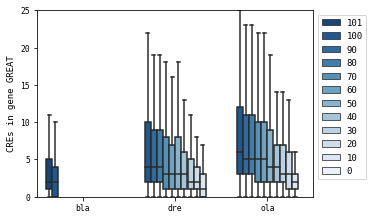

In [13]:
Fwidth = THESIS_PAGEWIDTH
Fheight = Fwidth*(9/16.)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.10, bottom=.08, right=.85, top=.98)

# ax.set_title('ATACseq peak numbers overview')
sns.boxplot(
    data=toplot,
    
    x = 'species',
    order= ['bla','dre','ola'],
    hue='pc',
    hue_order=[101,100,90,80,70,60,50,40,30,20,10,0],
    
    fliersize=0,
    y='count',
    palette='Blues_r'
)
# ax.set_xlim(0, 3*np.pi)
ax.set_ylim((0,25))
# plt.legend(loc='upper left')

# for label in ax.get_xticklabels():
#         label.set_rotation(45) 
     
plt.legend(loc='upper left')
#>>> Name your Axes
ax.set_ylabel('CREs in gene GREAT')
ax.set_xlabel('')
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")
plt.legend(bbox_to_anchor=(1.0, 1), )

fig.set_size_inches (Fwidth, Fheight)
fig.savefig('../Figures/from_notebooks/tfigure_downsampling.pdf')

Let's calculate some PValues:

In [14]:
lot = []
blavals = (toplot
    .loc[(toplot.species=='bla') & (toplot.pc==101),'count'].values)
blavals_sub = (toplot
    .loc[(toplot.species=='bla') & (toplot.pc==100),'count'].values)

for gn,g in toplot.groupby(['species','pc']):
    species,pc = gn
    if species=='bla':
        continue
    pv = MWU( g['count'].values , blavals,
             alternative='greater' ).pvalue
    pv_sub = MWU( g['count'].values , blavals_sub, 
                 alternative='greater' ).pvalue
    
    lot.append([ species, pc, pv_sub,pv])
    
    
df = pd.DataFrame(lot)
df.columns = ['species','% of reads','pVal to downsampled Amphi',
              'pVal to full Amphi']
df.sample(3)

species  % of reads  pVal to downsampled Amphi  pVal to full Amphi
4      dre          40              3.859252e-283        1.817653e-94
17     ola          60               0.000000e+00        0.000000e+00
7      dre          70               0.000000e+00       3.523587e-268